In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import keras.backend as K
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import SimpleRNN, Dense, Embedding, Input, GRU, LSTM, Dropout, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Loading dataset and initial preprocessing

In [ ]:
dfc = pd.read_csv("poem_classification.csv")
dfc.head()

,author,content,poem name,Label
0,WILLIAM SHAKESPEARE,Let the bird of loudest lay\r\nOn the sole Ara...,The Phoenix and the Turtle,1
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,"Sir Charles into my chamber coming in,\r\nWhen...",An Epilogue to the Above,1
2,THOMAS BASTARD,"Our vice runs beyond all that old men saw,\r\n...","Book 7, Epigram 42",1
3,EDMUND SPENSER,"Lo I the man, whose Muse whilome did maske,\r\...","from The Faerie Queene: Book I, Canto I",1
4,RICHARD BARNFIELD,"Long have I longd to see my love againe,\r\nSt...",Sonnet 16,1


In [ ]:
dfc.count()

author       1897
content      1897
poem name    1895
Label        1897
dtype: int64

In [ ]:
dfc["poem name"] = dfc["poem name"].replace(np.nan, "Unknown")

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop = stopwords.words('english')
dfc["content"] = dfc["content"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
import string
dfc["content"] = dfc["content"].apply(lambda x: "".join([t for t in x if t not in string.punctuation]))

In [ ]:
dfc["content"] = dfc["content"].apply(lambda x: x.lower())

In [ ]:
import re
dfg = open('poemgen.txt',encoding="utf8").read()
dfg = re.sub(r'[^\w\s]','',dfg)
dfg = dfg.lower().split("\n")

In [ ]:
pip install -U gensim

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import gensim
from gensim.parsing.preprocessing import remove_stopwords
lg = []
for w in dfg:
    w = remove_stopwords(w)
    lg.append(w)
lg

['imbroglio self',
 '',
 'shadows cast cave walls',
 'imprinting scurrilous insecurity',
 'compensate servility',
 'sheep wolfs clothing calls',
 '',
 'god prayers',
 'bleed spears asperity intact',
 'inebriated delusions debilitating fact',
 'haciendas built domesticate',
 '',
 'self melancholy worth euphoria',
 'intrinsic journey self',
 'dont bury hatchet burn shelf',
 'renounce fantasy welcome budding new utopia',
 '',
 'head',
 '',
 'hiding',
 'eclipse doesnt hide maimed propriety',
 'blood hands blood mind',
 'monotonous rhythms desolate life',
 'life worth',
 'depressed bitch chronicles',
 'stop blabbing inside head',
 'road hell mapped',
 'hot coal feet dont feel',
 'thoughts plaguing torpedo mind',
 'light breathe',
 'walking bare feet shards shattered dreams',
 'reticent underdog potential',
 'taciturn',
 'thoughts turning inside head',
 'way',
 'want win way',
 'victory escape inevitable',
 'desirous',
 'want proud',
 'layers pretense societal conditioning',
 'god child',
 '

### Exporing the distribution and overarching themes conveyed by poetry

In [ ]:
pip install wordcloud

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp310-cp310-win_amd64.whl size=161174 sha256=0608793790557810adc1b5196af40f630eb566c9f3fde9b5bb7580515f4c25ca
  Stored in directory: c:\users\owner\appdata\local\pip\cache\wheels\6b\b1\75\024072f28a2b9d6c4f80b35ebfd6ced7fd9fc58e9f1b933b9f
Successfully built wordcloud
Note: you may need to restart the kernel to use updated packages.


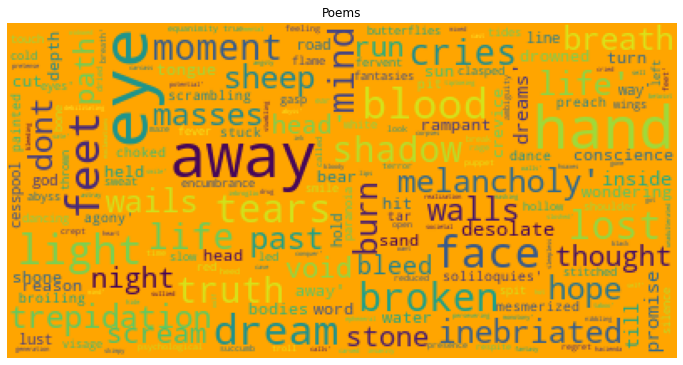

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(
                          background_color='orange',
                          max_words=200,
                          max_font_size=40,
                          random_state=15
                         ).generate(str(lg))

fig = plt.figure(1,figsize=(12,18))
plt.imshow(wordcloud)
plt.title('Poems in generation dataset')
plt.axis('off')
plt.show()

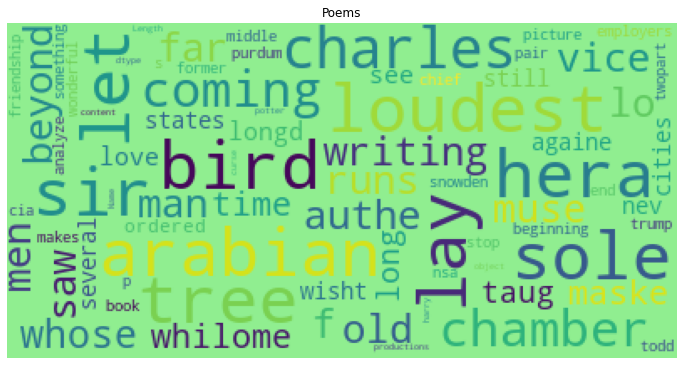

In [ ]:
wordcloud = WordCloud(
                          background_color='lightgreen',
                          max_words=200,
                          max_font_size=40,
                          random_state=15
                         ).generate(str(dfc['content']))

fig = plt.figure(1,figsize=(12,18))
plt.imshow(wordcloud)
plt.title('Poems in classification dataset')
plt.axis('off')
plt.show()

In [ ]:
dfc['author'].value_counts()

WILLIAM SHAKESPEARE     71
SIR PHILIP SIDNEY       42
JOHN DONNE              41
  NATALIE PROULX        34
EDMUND SPENSER          34
                        ..
  J. DAVID GOODMAN       1
  LILLY LEDBETTER        1
  ZEYNEP TUFEKCI         1
  WENDELL P. GORING      1
  JASON ROBERT BROWN     1
Name: author, Length: 833, dtype: int64

In [ ]:
dfc['Label'].value_counts()

0    1324
1     573
Name: Label, dtype: int64

### Distribution of Genres of poetry for reference

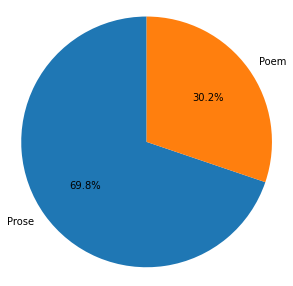

In [ ]:
labels = 'Prose', 'Poem'
sizes = [1324, 573]


fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')

plt.show()

## Preprocessing and Classification

In [ ]:
dfc.head()

,author,content,poem name,Label
0,WILLIAM SHAKESPEARE,let bird loudest lay on sole arabian tree hera...,The Phoenix and the Turtle,1
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,sir charles chamber coming in when i writing f...,An Epilogue to the Above,1
2,THOMAS BASTARD,our vice runs beyond old men saw and far authe...,"Book 7, Epigram 42",1
3,EDMUND SPENSER,lo i man whose muse whilome maske as time taug...,"from The Faerie Queene: Book I, Canto I",1
4,RICHARD BARNFIELD,long i longd see love againe still i wisht nev...,Sonnet 16,1


In [ ]:
#tokenization
import re
dfc["content"] = dfc["content"].apply(lambda x: re.split('W+', x))
dfc.head()

,author,content,poem name,Label
0,WILLIAM SHAKESPEARE,[let bird loudest lay on sole arabian tree her...,The Phoenix and the Turtle,1
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,[sir charles chamber coming in when i writing ...,An Epilogue to the Above,1
2,THOMAS BASTARD,[our vice runs beyond old men saw and far auth...,"Book 7, Epigram 42",1
3,EDMUND SPENSER,[lo i man whose muse whilome maske as time tau...,"from The Faerie Queene: Book I, Canto I",1
4,RICHARD BARNFIELD,[long i longd see love againe still i wisht ne...,Sonnet 16,1


In [ ]:
#stemming
ps = PorterStemmer()
dfc['content'] = dfc['content'].apply(lambda x: [ps.stem(word) for word in x])
dfc.head()

,author,content,poem name,Label
0,WILLIAM SHAKESPEARE,[let bird loudest lay on sole arabian tree her...,The Phoenix and the Turtle,1
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,[sir charles chamber coming in when i writing ...,An Epilogue to the Above,1
2,THOMAS BASTARD,[our vice runs beyond old men saw and far auth...,"Book 7, Epigram 42",1
3,EDMUND SPENSER,[lo i man whose muse whilome maske as time tau...,"from The Faerie Queene: Book I, Canto I",1
4,RICHARD BARNFIELD,[long i longd see love againe still i wisht ne...,Sonnet 16,1


In [ ]:
dfc["content"] = dfc["content"].apply(str)

In [ ]:
dfc["content"].shape

(1897,)

In [ ]:
#vectorization
from sklearn.feature_extraction.text import TfidfTransformer
x=dfc["content"]
cv = CountVectorizer()
cv.fit_transform(x)
ftm = cv.transform(x)

In [ ]:
y = dfc['Label']

In [ ]:
tfidf = TfidfTransformer(norm="l2")
tfidf.fit(ftm)
tim = tfidf.fit_transform(ftm)
tim

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tim, y, test_size=0.2, random_state=87)

In [ ]:
x_test.shape

(380, 16737)

### SVM

In [ ]:
from sklearn import svm
svm = svm.SVC()
svm.fit(x_train, y_train)
yhat_svm = svm.predict(x_test)

In [ ]:
yhat_svm = svm.predict(x_test)

In [ ]:
# 67 - 87
from sklearn.metrics import classification_report
print(classification_report(y_test, yhat_svm))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       263
           1       0.99      0.91      0.95       117

    accuracy                           0.97       380
   macro avg       0.98      0.96      0.97       380
weighted avg       0.97      0.97      0.97       380



### PAC

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier()
pac.fit(x_train, y_train)
yhat_p = pac.predict(x_test)

In [ ]:
x_test

<380x16737 sparse matrix of type '<class 'numpy.float64'>'
	with 12824 stored elements in Compressed Sparse Row format>

In [ ]:
print(classification_report(y_test, yhat_p))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       263
           1       0.98      0.97      0.98       117

    accuracy                           0.99       380
   macro avg       0.99      0.98      0.98       380
weighted avg       0.99      0.99      0.99       380



## Using Neural Networks to generate poetry

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lg)

In [ ]:
total_words = len(tokenizer.word_index)+1
total_words

1951

In [ ]:
input_sequences = []
for line in lg:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [ ]:
max_seq_len = max([len(x) for x in input_sequences])
max_seq_len

16

In [ ]:
embed_dim = 64

In [ ]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre'))
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

### Simple RNN

In [ ]:
model1 = Sequential()
model1.add(Embedding(total_words, 100, input_length=max_seq_len-1))
model1.add(SimpleRNN(150, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(SimpleRNN(100))
model1.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dense(total_words, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           195100    
                                                                 
 simple_rnn (SimpleRNN)      (None, 15, 150)           37650     
                                                                 
 dropout (Dropout)           (None, 15, 150)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               25100     
                                                                 
 dense (Dense)               (None, 975)               98475     
                                                                 
 dense_1 (Dense)             (None, 1951)              1904176   
                                                                 
Total params: 2,260,501
Trainable params: 2,260,501
Non-

In [ ]:
history1 = model1.fit(predictors, label, epochs=200, verbose=1, batch_size=90)

Epoch 1/200
25/25 [==============================] - 6s 63ms/step - loss: 8.8312 - accuracy: 0.0062
Epoch 2/200
25/25 [==============================] - 1s 51ms/step - loss: 7.9630 - accuracy: 0.0107
Epoch 3/200
25/25 [==============================] - 1s 52ms/step - loss: 7.6091 - accuracy: 0.0107
Epoch 4/200
25/25 [==============================] - 1s 51ms/step - loss: 7.4809 - accuracy: 0.0107
Epoch 5/200
25/25 [==============================] - 1s 51ms/step - loss: 7.4353 - accuracy: 0.0107
Epoch 6/200
25/25 [==============================] - 1s 52ms/step - loss: 7.4116 - accuracy: 0.0094
Epoch 7/200
25/25 [==============================] - 1s 52ms/step - loss: 7.3904 - accuracy: 0.0107
Epoch 8/200
25/25 [==============================] - 1s 54ms/step - loss: 7.3682 - accuracy: 0.0107
Epoch 9/200
25/25 [==============================] - 2s 61ms/step - loss: 7.3599 - accuracy: 0.0107
Epoch 10/200
25/25 [==============================] - 1s 58ms/step - loss: 7.3496 - accuracy: 0.0107

25/25 [==============================] - 1s 52ms/step - loss: 1.4845 - accuracy: 0.8662
Epoch 163/200
25/25 [==============================] - 1s 49ms/step - loss: 1.4708 - accuracy: 0.8617
Epoch 164/200
25/25 [==============================] - 1s 49ms/step - loss: 1.4460 - accuracy: 0.8671
Epoch 165/200
25/25 [==============================] - 1s 48ms/step - loss: 1.4161 - accuracy: 0.8814
Epoch 166/200
25/25 [==============================] - 1s 48ms/step - loss: 1.3925 - accuracy: 0.8782
Epoch 167/200
25/25 [==============================] - 1s 48ms/step - loss: 1.3728 - accuracy: 0.8822
Epoch 168/200
25/25 [==============================] - 1s 48ms/step - loss: 1.3391 - accuracy: 0.8947
Epoch 169/200
25/25 [==============================] - 1s 49ms/step - loss: 1.3179 - accuracy: 0.9028
Epoch 170/200
25/25 [==============================] - 1s 48ms/step - loss: 1.2936 - accuracy: 0.8965
Epoch 171/200
25/25 [==============================] - 1s 49ms/step - loss: 1.2783 - accuracy: 0

In [ ]:
def rnn_poems(seed_text):
    for _ in range(50):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        predicted = model1.predict(token_list, verbose=0)
        classes_x=np.argmax(predicted,axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == classes_x:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [ ]:
rnnp = []
rnnp.append(rnn_poems("What is this life"))
rnnp.append(rnn_poems("Crescent moon blinks"))
rnnp.append(rnn_poems("Mysterious afair in style"))
rnnp.append(rnn_poems("Curtain flung away"))
rnnp.append(rnn_poems("Nature at the behest"))
rnnp.append(rnn_poems("Lighthouse looming in dusk"))
rnnp.append(rnn_poems("Dreams and reveries"))
rnnp.append(rnn_poems("Islandic voyages into the"))
rnnp.append(rnn_poems("Deep space brings"))
rnnp.append(rnn_poems("To the table"))
rnnp.append(rnn_poems("Theism manifests"))
rnnp.append(rnn_poems("Bank orbit stellar"))
rnnp.append(rnn_poems("Meancholic medey of day"))
rnnp.append(rnn_poems("Footsteps creak under floorboards"))
rnnp.append(rnn_poems("Beauty is benign"))
rnnp.append(rnn_poems("Come as you are"))
rnnp.append(rnn_poems("Something in the way"))
rnnp.append(rnn_poems("Heart shaped box opens up"))
rnnp.append(rnn_poems("I like data science"))
rnnp.append(rnn_poems("Poison in the veins"))
rnnp.append(rnn_poems("Burn the rain in its glory"))
rnnp.append(rnn_poems("Steaing glances from a distance"))
rnnp.append(rnn_poems("Lying on the deathbed"))
rnnp.append(rnn_poems("Marigold plants flourish"))
rnnp.append(rnn_poems("Barren field awaits tempest"))
rnnp.append(rnn_poems("Letter to myself"))
rnnp.append(rnn_poems("Lake of fire"))
rnnp.append(rnn_poems("Touch the sky and reach higher"))
rnnp.append(rnn_poems("It all falls down"))
rnnp.append(rnn_poems("Roses bring me down"))
rnnp.append(rnn_poems("Thorns at the crest"))
rnnp.append(rnn_poems("Addiction to perspiration"))
rnnp.append(rnn_poems("Old friends lie still"))
rnnp.append(rnn_poems("Sick with vision"))
rnnp.append(rnn_poems("Fire in the hole"))
rnnp.append(rnn_poems("Walking in the snow"))
rnnp.append(rnn_poems("A few words to the sky"))
rnnp.append(rnn_poems("Breathe the air"))
rnnp.append(rnn_poems("Somebody close to you"))
rnnp.append(rnn_poems("Rivers carve paths"))
rnnp.append(rnn_poems("The sky in its magnanimity"))
rnnp.append(rnn_poems("Rain falls on every soul"))
rnnp.append(rnn_poems("I will look after you"))
rnnp.append(rnn_poems("The road less travelled by"))
rnnp.append(rnn_poems("Ivy leaves scatter about in fall"))
rnnp.append(rnn_poems("She spent her ife building"))
rnnp.append(rnn_poems("How dreary to be somebody"))
rnnp.append(rnn_poems("Life is a broken-winged bird"))
rnnp.append(rnn_poems("Your heart break leaves you feeling blue"))
rnnp.append(rnn_poems("Started from nothing and here we are"))

In [ ]:
rnnp

['What is this life meaning cruel freed hide false exasperated exasperations sunlight spit bind screams wilt away abandonment melancholy threw facade master astray pleasure memories core hedonistic stumble hypnotized past parity mistaken firebrands image ash limbo lights away feet dreams tremors feigns stocked fireplace smothered crack oxygen trophy sculpted perversion trances space alienating reality',
 'Crescent moon blinks away lurking swig runs dry mind dumbfounded agony smitten damsel feigns ring limbic loops inconsequential pastors led puppet dreams away memories ring memories masochism recompense fables held flickering eyes unctuously fantasy asperity dependence clarity pray soliloquies generation raw disconnect disbanded sculpted perversion reveal crooned damaged memories interwoven stitched close melancholy',
 'Mysterious afair in style bleeding words wedged batter begrudging bakery echo serenity broken procuring poisoned prunes engagement pastors mongering mortalities alienat

In [ ]:
dfrnn = pd.DataFrame(rnnp, columns=['Poem'])
dfrnn.head(10)

,Poem
0,What is this life meaning cruel freed hide fal...
1,Crescent moon blinks away lurking swig runs dr...
2,Mysterious afair in style bleeding words wedge...
3,Curtain flung away runs long feet leave earth ...
4,Nature at the behest affiliation parity fables...
5,Lighthouse looming in dusk kept vacant desolat...
6,Dreams and reveries fables held grasp sigh rel...
7,Islandic voyages into the bleeding words wedge...
8,Deep space brings barren youth glances fit lip...
9,To the table bleeding words wedged batter begr...


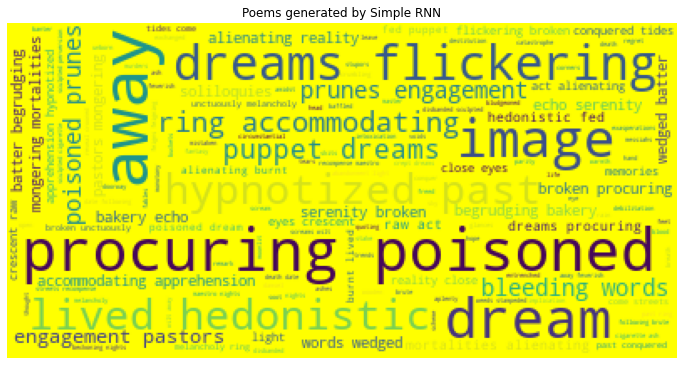

In [ ]:
wordcloud = WordCloud(
                          background_color='yellow',
                          max_words=200,
                          max_font_size=40,
                          random_state=15
                         ).generate(' '.join(dfrnn['Poem']))

fig = plt.figure(1,figsize=(12,18))
plt.imshow(wordcloud)
plt.title('Poems generated by Simple RNN')
plt.axis('off')
plt.show()

### LSTM

In [ ]:
import keras
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 100)           195100    
                                                                 
 bidirectional (Bidirectiona  (None, 15, 300)          301200    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 15, 300)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 975)               195975    
                                                                 
 dense_3 (Dense)             (None, 1951)             

In [ ]:
history = model.fit(predictors, label, epochs=200, verbose=1, batch_size=90)

Epoch 1/200
25/25 [==============================] - 10s 147ms/step - loss: 9.6034 - accuracy: 0.0071
Epoch 2/200
25/25 [==============================] - 4s 149ms/step - loss: 8.0818 - accuracy: 0.0107
Epoch 3/200
25/25 [==============================] - 4s 146ms/step - loss: 7.5872 - accuracy: 0.0107
Epoch 4/200
25/25 [==============================] - 4s 147ms/step - loss: 7.4149 - accuracy: 0.0107
Epoch 5/200
25/25 [==============================] - 4s 157ms/step - loss: 7.3049 - accuracy: 0.0107
Epoch 6/200
25/25 [==============================] - 4s 151ms/step - loss: 7.2058 - accuracy: 0.0107
Epoch 7/200
25/25 [==============================] - 4s 160ms/step - loss: 7.0991 - accuracy: 0.0107
Epoch 8/200
25/25 [==============================] - 4s 151ms/step - loss: 7.0045 - accuracy: 0.0089
Epoch 9/200
25/25 [==============================] - 4s 146ms/step - loss: 6.9062 - accuracy: 0.0103
Epoch 10/200
25/25 [==============================] - 4s 147ms/step - loss: 6.7993 - accur

25/25 [==============================] - 4s 165ms/step - loss: 1.5580 - accuracy: 0.7725
Epoch 161/200
25/25 [==============================] - 4s 164ms/step - loss: 1.5818 - accuracy: 0.7765
Epoch 162/200
25/25 [==============================] - 4s 165ms/step - loss: 1.5314 - accuracy: 0.7890
Epoch 163/200
25/25 [==============================] - 4s 149ms/step - loss: 1.4700 - accuracy: 0.8015
Epoch 164/200
25/25 [==============================] - 4s 151ms/step - loss: 1.4159 - accuracy: 0.8216
Epoch 165/200
25/25 [==============================] - 4s 149ms/step - loss: 1.3814 - accuracy: 0.8238
Epoch 166/200
25/25 [==============================] - 4s 149ms/step - loss: 1.3423 - accuracy: 0.8385
Epoch 167/200
25/25 [==============================] - 4s 151ms/step - loss: 1.3279 - accuracy: 0.8439
Epoch 168/200
25/25 [==============================] - 4s 151ms/step - loss: 1.2996 - accuracy: 0.8457
Epoch 169/200
25/25 [==============================] - 4s 150ms/step - loss: 1.2802 - a

In [ ]:
def lstm_poems(seed_text):
    for _ in range(50):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        classes_x=np.argmax(predicted,axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == classes_x:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [ ]:
lstmp = []
lstmp.append(lstm_poems("What is this life"))
lstmp.append(lstm_poems("Crescent moon blinks"))
lstmp.append(lstm_poems("Mysterious afair in style"))
lstmp.append(lstm_poems("Curtain flung away"))
lstmp.append(lstm_poems("Nature at the behest"))
lstmp.append(lstm_poems("Lighthouse looming in dusk"))
lstmp.append(lstm_poems("Dreams and reveries"))
lstmp.append(lstm_poems("Islandic voyages into the"))
lstmp.append(lstm_poems("Deep space brings"))
lstmp.append(lstm_poems("To the table"))
lstmp.append(lstm_poems("Theism manifests"))
lstmp.append(lstm_poems("Bank orbit stellar"))
lstmp.append(lstm_poems("Meancholic medey of day"))
lstmp.append(lstm_poems("Footsteps creak under floorboards"))
lstmp.append(lstm_poems("Beauty is benign"))
lstmp.append(lstm_poems("Come as you are"))
lstmp.append(lstm_poems("Something in the way"))
lstmp.append(lstm_poems("Heart shaped box opens up"))
lstmp.append(lstm_poems("I like data science"))
lstmp.append(lstm_poems("Poison in the veins"))
lstmp.append(lstm_poems("Burn the rain in its glory"))
lstmp.append(lstm_poems("Steaing glances from a distance"))
lstmp.append(lstm_poems("Lying on the deathbed"))
lstmp.append(lstm_poems("Marigold plants flourish"))
lstmp.append(lstm_poems("Barren field awaits tempest"))
lstmp.append(lstm_poems("Letter to myself"))
lstmp.append(lstm_poems("Lake of fire"))
lstmp.append(lstm_poems("Touch the sky and reach higher"))
lstmp.append(lstm_poems("It all falls down"))
lstmp.append(lstm_poems("Roses bring me down"))
lstmp.append(lstm_poems("Thorns at the crest"))
lstmp.append(lstm_poems("Addiction to perspiration"))
lstmp.append(lstm_poems("Old friends lie still"))
lstmp.append(lstm_poems("Sick with vision"))
lstmp.append(lstm_poems("Fire in the hole"))
lstmp.append(lstm_poems("Walking in the snow"))
lstmp.append(lstm_poems("A few words to the sky"))
lstmp.append(lstm_poems("Breathe the air"))
lstmp.append(lstm_poems("Somebody close to you"))
lstmp.append(lstm_poems("Rivers carve paths"))
lstmp.append(lstm_poems("The sky in its magnanimity"))
lstmp.append(lstm_poems("Rain falls on every soul"))
lstmp.append(lstm_poems("I will look after you"))
lstmp.append(lstm_poems("The road less travelled by"))
lstmp.append(lstm_poems("Ivy leaves scatter about in fall"))
lstmp.append(lstm_poems("She spent her ife building"))
lstmp.append(lstm_poems("How dreary to be somebody"))
lstmp.append(lstm_poems("Life is a broken-winged bird"))
lstmp.append(lstm_poems("Your heart break leaves you feeling blue"))
lstmp.append(lstm_poems("Started from nothing and here we are"))

In [ ]:
lstmp

['What is this life worth countenance dysphoria relief relief escaped jealousy moonlit melancholy misconstructions misconstructions lachrymosity shadows troll sucking framed despairs possibilities scheme nature moonlit hegemony fall date skits tires resentment cocktail leaking image tranquility renditions validate validate tremors implication shimmering woeful reveal pages depraved pastors renditions renditions cocktail ambition image pastors pastors renditions',
 'Crescent moon blinks inside exclamations breath sullied light desperate held testimony mixed white woe ignorance validate implication implication tremors relief conquest conquest tremors hegemony conscientious beckoned sound slung fostering tossed aside lash doctrinaire scheme shatters shatters fall ambition image pastors pastors renditions cocktail leaking image pastors renditions cocktail date skits tires cocktail concocting',
 'Mysterious afair in style cough repeat chase taboo focused weasel doctrinaire renditions rendit

In [ ]:
dflstm = pd.DataFrame(lstmp, columns=['Poem'])
dflstm.head(10)

,Poem
0,What is this life worth countenance dysphoria ...
1,Crescent moon blinks inside exclamations breat...
2,Mysterious afair in style cough repeat chase t...
3,Curtain flung away stipulated suspended somber...
4,Nature at the behest necessity kettles teapots...
5,Lighthouse looming in dusk holy knightedness c...
6,Dreams and reveries fables held grasp sigh rel...
7,Islandic voyages into the cough repeat chase t...
8,Deep space brings python mirror debilitating c...
9,To the table cough repeat chase taboo focused ...


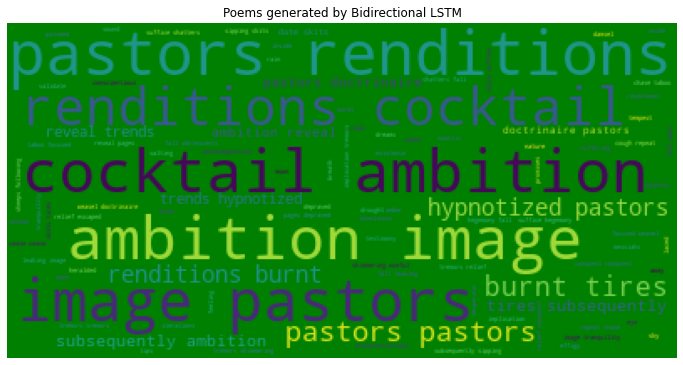

In [ ]:
wordcloud = WordCloud(
                          background_color='green',
                          max_font_size=40,
                          random_state=15
                         ).generate(' '.join(dflstm['Poem']))

fig = plt.figure(1,figsize=(12,18))
plt.imshow(wordcloud)
plt.title('Poems generated by Bidirectional LSTM')
plt.axis('off')
plt.show()

### GRU

In [ ]:
gru = Sequential()
gru.add(Embedding(total_words, 100, input_length=max_seq_len-1))
gru.add(GRU(150, return_sequences = True))
gru.add(Dropout(0.2))
gru.add(GRU(100))
gru.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
gru.add(Dense(total_words, activation='softmax'))
gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 15, 100)           195100    
                                                                 
 gru (GRU)                   (None, 15, 150)           113400    
                                                                 
 dropout_2 (Dropout)         (None, 15, 150)           0         
                                                                 
 gru_1 (GRU)                 (None, 100)               75600     
                                                                 
 dense_4 (Dense)             (None, 975)               98475     
                                                                 
 dense_5 (Dense)             (None, 1951)              1904176   
                                                                 
Total params: 2,386,751
Trainable params: 2,386,751
No

In [ ]:
history2 = gru.fit(predictors, label, epochs=200, verbose=1, batch_size=90)

Epoch 1/200
25/25 [==============================] - 6s 72ms/step - loss: 8.7124 - accuracy: 0.0085
Epoch 2/200
25/25 [==============================] - 2s 73ms/step - loss: 7.8577 - accuracy: 0.0107
Epoch 3/200
25/25 [==============================] - 2s 72ms/step - loss: 7.5324 - accuracy: 0.0107
Epoch 4/200
25/25 [==============================] - 2s 72ms/step - loss: 7.3857 - accuracy: 0.0107
Epoch 5/200
25/25 [==============================] - 2s 72ms/step - loss: 7.2793 - accuracy: 0.0107
Epoch 6/200
25/25 [==============================] - 2s 71ms/step - loss: 7.1777 - accuracy: 0.0107
Epoch 7/200
25/25 [==============================] - 2s 72ms/step - loss: 7.0514 - accuracy: 0.0107
Epoch 8/200
25/25 [==============================] - 2s 74ms/step - loss: 6.8762 - accuracy: 0.0107
Epoch 9/200
25/25 [==============================] - 2s 73ms/step - loss: 6.7611 - accuracy: 0.0112
Epoch 10/200
25/25 [==============================] - 2s 70ms/step - loss: 6.6440 - accuracy: 0.0116

25/25 [==============================] - 2s 76ms/step - loss: 0.7298 - accuracy: 0.9344
Epoch 163/200
25/25 [==============================] - 2s 74ms/step - loss: 0.7226 - accuracy: 0.9318
Epoch 164/200
25/25 [==============================] - 2s 75ms/step - loss: 0.7130 - accuracy: 0.9344
Epoch 165/200
25/25 [==============================] - 2s 76ms/step - loss: 0.7052 - accuracy: 0.9384
Epoch 166/200
25/25 [==============================] - 2s 75ms/step - loss: 0.6933 - accuracy: 0.9371
Epoch 167/200
25/25 [==============================] - 2s 74ms/step - loss: 0.6895 - accuracy: 0.9340
Epoch 168/200
25/25 [==============================] - 2s 75ms/step - loss: 0.6761 - accuracy: 0.9425
Epoch 169/200
25/25 [==============================] - 2s 74ms/step - loss: 0.6783 - accuracy: 0.9389
Epoch 170/200
25/25 [==============================] - 2s 75ms/step - loss: 0.6688 - accuracy: 0.9367
Epoch 171/200
25/25 [==============================] - 2s 75ms/step - loss: 0.6648 - accuracy: 0

In [ ]:
def gru_poems(seed_text):
    for _ in range(50):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        predicted = gru.predict(token_list, verbose=0)
        classes_x=np.argmax(predicted,axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == classes_x:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [ ]:
grup = []
grup.append(gru_poems("What is this life"))
grup.append(gru_poems("Crescent moon blinks"))
grup.append(gru_poems("Mysterious affair in style"))
grup.append(gru_poems("Curtain flung away"))
grup.append(gru_poems("Nature at the behest"))
grup.append(gru_poems("Lighthouse looming in dusk"))
grup.append(gru_poems("Dreams and reveries"))
grup.append(gru_poems("Islandic voyages into the"))
grup.append(gru_poems("Deep space brings"))
grup.append(gru_poems("To the table"))
grup.append(gru_poems("Theism manifests"))
grup.append(gru_poems("Bank orbit stellar"))
grup.append(gru_poems("Meancholic medley of day"))
grup.append(gru_poems("Footsteps creak under floorboards"))
grup.append(gru_poems("Beauty is benign"))
grup.append(gru_poems("Come as you are"))
grup.append(gru_poems("Something in the way"))
grup.append(gru_poems("Heart shaped box opens up"))
grup.append(gru_poems("I like data science"))
grup.append(gru_poems("Poison in the veins"))
grup.append(gru_poems("Burn the rain in its glory"))
grup.append(gru_poems("Stealing glances from a distance"))
grup.append(gru_poems("Lying on the deathbed"))
grup.append(gru_poems("Marigold plants flourish"))
grup.append(gru_poems("Barren field awaits tempest"))
grup.append(gru_poems("Letter to myself"))
grup.append(gru_poems("Lake of fire"))
grup.append(gru_poems("Touch the sky and reach higher"))
grup.append(gru_poems("It all falls down"))
grup.append(gru_poems("Roses bring me down"))
grup.append(gru_poems("Thorns at the crest"))
grup.append(gru_poems("Addiction to perspiration"))
grup.append(gru_poems("Old friends lie still"))
grup.append(gru_poems("Sick with vision"))
grup.append(gru_poems("Fire in the hole"))
grup.append(gru_poems("Walking in the snow"))
grup.append(gru_poems("A few words to the sky"))
grup.append(gru_poems("Breathe the air"))
grup.append(gru_poems("Somebody close to you"))
grup.append(gru_poems("Rivers carve paths"))
grup.append(gru_poems("The sky in its magnanimity"))
grup.append(gru_poems("Rain falls on every soul"))
grup.append(gru_poems("I will look after you"))
grup.append(gru_poems("The road less travelled by"))
grup.append(gru_poems("Ivy leaves scatter about in fall"))
grup.append(gru_poems("She spent her life building"))
grup.append(gru_poems("How dreary to be somebody"))
grup.append(gru_poems("Life is a broken-winged bird"))
grup.append(gru_poems("Your heart break leaves you feeling blue"))
grup.append(gru_poems("Started from nothing and here we are"))

In [ ]:
grup

['What is this life worth restrained selfreflection hide broken masks till firebrands asymptomatic act patched masculinity clarity tempest burnt tires whined crooned crooned trends hypnotized eyes eyes tires skits reality reality writing reality hope flesh reality firebrands significance asphyxiate aspersions calls ambition image skits reality reality reality reality reality reality reality reality exasperations aspersions',
 'Crescent moon blinks melancholy firebrands animosity patched alienating reality reality reality reality reality reality reality reality reality reality reality reality reality illusory dependence reduced calls displays blurry benders exasperations aspersions drowned cocktail ambition image skits reality reality reality reality exasperations flesh displays blurry benders writing writing reality reality exasperations aspersions drowned cocktail ambition',
 'Mysterious afair in style reach ceiling caress bloodstains asphyxiate exhaust sinner reality reality exaspera

In [ ]:
dfgru = pd.DataFrame(grup, columns=['Poem'])
dfgru.head(10)

,Poem
0,What is this life worth restrained selfreflect...
1,Crescent moon blinks melancholy firebrands ani...
2,Mysterious afair in style reach ceiling caress...
3,Curtain flung away wailing cries widowed ambit...
4,Nature at the behest danced dusk silenced scre...
5,Lighthouse looming in dusk rocked push soon di...
6,Dreams and reveries fables held grasp sigh rel...
7,Islandic voyages into the reach ceiling caress...
8,Deep space brings sigh shackled foot dally pag...
9,To the table reach ceiling caress bloodstains ...


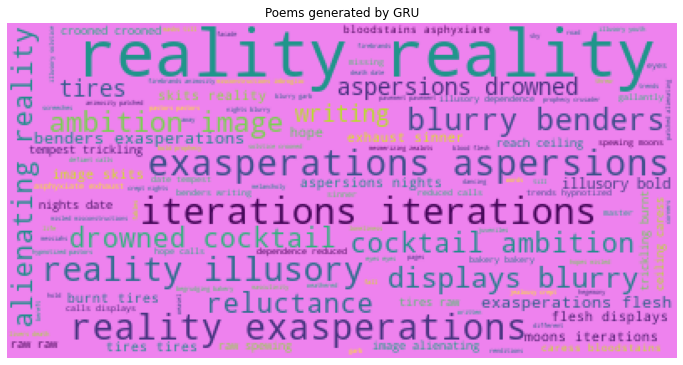

In [ ]:
wordcloud = WordCloud(
                          background_color='violet',
                          max_font_size=40,
                          random_state=15
                         ).generate(' '.join(dfgru['Poem']))

fig = plt.figure(1,figsize=(12,18))
plt.imshow(wordcloud)
plt.title('Poems generated by GRU')
plt.axis('off')
plt.show()